In [60]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]

def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

# Convert the principal components into a DataFrame
# add a column for the label
esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

num_metastructures = 50

# Find 0.05 and 0.95 quantiles of PC1 and PC2 data
pc1_05 = all_df['PC1'].quantile(0.01)
pc1_95 = all_df['PC1'].quantile(0.99)
pc2_05 = all_df['PC2'].quantile(0.01)
pc2_95 = all_df['PC2'].quantile(0.99)

pc1_grid = np.linspace(pc1_05, pc1_95, num_metastructures)
pc2_grid = np.linspace(pc2_05, pc2_95, num_metastructures)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)


In [61]:

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)

In [72]:
num_metastructures

50

In [62]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 

common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240812_WeightMCMC_PCA_metastructures_3/'

stan_directory_esc = os.path.join(common_dir, 'ESC/stan_output')
stan_directory_cnc = os.path.join(common_dir, 'CNC/stan_output')
stan_directory_all = os.path.join(common_dir, 'all/stan_output')

esc_log_weights = load_weights(stan_directory_esc, num_metastructures**2)
cnc_log_weights = load_weights(stan_directory_cnc, num_metastructures**2)

esc_weights = np.mean(np.exp(np.array(esc_log_weights)), axis=(0, 1))
cnc_weights = np.mean(np.exp(np.array(cnc_log_weights)), axis=(0, 1))

# Put weights in a DataFrame
esc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values,  
                               'weight': esc_weights})
esc_weights_df['label'] = 'ESC'
cnc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values, 
                               'weight': cnc_weights})
cnc_weights_df['label'] = 'CNC'


['20240715_WeightOptimization-20240812175231_1.csv', '20240715_WeightOptimization-20240812175231_2.csv', '20240715_WeightOptimization-20240812175231_3.csv', '20240715_WeightOptimization-20240812175231_4.csv']
['20240715_WeightOptimization-20240812180729_1.csv', '20240715_WeightOptimization-20240812180729_2.csv', '20240715_WeightOptimization-20240812180729_3.csv', '20240715_WeightOptimization-20240812180729_4.csv']


In [73]:
esc_log_weights[0, :]

array([[ -8.3641948,  -9.4459848,  -7.5100598, ...,  -8.6906762,
         -7.9571845,  -8.8329518],
       [ -6.8162933,  -6.737157 ,  -9.1111657, ...,  -8.3484952,
         -8.489914 ,  -7.8085571],
       [ -7.8207506, -10.856555 ,  -9.8434504, ...,  -8.8115303,
         -9.2116386,  -7.9038074],
       ...,
       [ -9.6694866,  -8.6803585,  -8.1591825, ...,  -8.3341621,
         -8.718165 ,  -7.2211653],
       [ -6.1782222,  -9.6520061,  -7.5947223, ...,  -9.9885691,
         -9.8592263, -11.069221 ],
       [ -8.9129566, -11.402486 ,  -9.1110584, ...,  -8.7098995,
         -9.3287949,  -8.4627644]])

In [63]:
pc1_unique = np.unique(pc1_pc2_df['PC1'])
pc2_unique = np.unique(pc1_pc2_df['PC2'])

In [64]:
pc1_unique

array([-24851.33427881, -23995.75253508, -23140.17079136, -22284.58904763,
       -21429.00730391, -20573.42556018, -19717.84381646, -18862.26207274,
       -18006.68032901, -17151.09858529, -16295.51684156, -15439.93509784,
       -14584.35335412, -13728.77161039, -12873.18986667, -12017.60812294,
       -11162.02637922, -10306.44463549,  -9450.86289177,  -8595.28114805,
        -7739.69940432,  -6884.1176606 ,  -6028.53591687,  -5172.95417315,
        -4317.37242943,  -3461.7906857 ,  -2606.20894198,  -1750.62719825,
         -895.04545453,    -39.4637108 ,    816.11803292,   1671.69977664,
         2527.28152037,   3382.86326409,   4238.44500782,   5094.02675154,
         5949.60849526,   6805.19023899,   7660.77198271,   8516.35372644,
         9371.93547016,  10227.51721389,  11083.09895761,  11938.68070133,
        12794.26244506,  13649.84418878,  14505.42593251,  15361.00767623,
        16216.58941995,  17072.17116368])

In [79]:
pc2_unique

array([-11871.66273546, -11373.9242478 , -10876.18576014, -10378.44727248,
        -9880.70878482,  -9382.97029716,  -8885.2318095 ,  -8387.49332183,
        -7889.75483417,  -7392.01634651,  -6894.27785885,  -6396.53937119,
        -5898.80088353,  -5401.06239587,  -4903.32390821,  -4405.58542055,
        -3907.84693288,  -3410.10844522,  -2912.36995756,  -2414.6314699 ,
        -1916.89298224,  -1419.15449458,   -921.41600692,   -423.67751926,
           74.0609684 ,    571.79945607,   1069.53794373,   1567.27643139,
         2065.01491905,   2562.75340671,   3060.49189437,   3558.23038203,
         4055.96886969,   4553.70735735,   5051.44584502,   5549.18433268,
         6046.92282034,   6544.661308  ,   7042.39979566,   7540.13828332,
         8037.87677098,   8535.61525864,   9033.35374631,   9531.09223397,
        10028.83072163,  10526.56920929,  11024.30769695,  11522.04618461,
        12019.78467227,  12517.52315993])

In [65]:
pc1_marginal_index = [np.where(pc1_pc2_df['PC1'] == x)[0] for x in pc1_unique]
pc2_marginal_index = [np.where(pc1_pc2_df['PC2'] == x)[0] for x in pc2_unique]

In [66]:
esc_entropy_all.shape

(4000,)

In [67]:
esc_weights_all = np.exp(np.array(esc_log_weights))
cnc_weights_all = np.exp(np.array(cnc_log_weights))

esc_weights_all = esc_weights_all.reshape(-1, 2500)
cnc_weights_all = cnc_weights_all.reshape(-1, 2500)

esc_entropy_all = np.array([scipy.stats.entropy(x) for x in esc_weights_all])
cnc_entropy_all = np.array([scipy.stats.entropy(x) for x in cnc_weights_all])

# Put these data in dataframe 
esc_entropy_df = pd.DataFrame({'entropy': esc_entropy_all, 'label': 'ESC'})
cnc_entropy_df = pd.DataFrame({'entropy': cnc_entropy_all, 'label': 'NPC'})

all_entropy_df = pd.concat([esc_entropy_df, cnc_entropy_df], axis=0)

In [74]:
esc_entropy_all[:5]

array([7.31809043, 7.33540839, 7.31562822, 7.32397892, 7.31981325])

In [68]:
pc1_marginal_prob = []
pc2_marginal_prob = []
for i in range(4000):
    pc1_list = []
    pc2_list = []
    for j in range(num_metastructures):
        pc1_list.append(np.sum(esc_weights_all[i, pc1_marginal_index[j]]))
        pc2_list.append(np.sum(esc_weights_all[i, pc2_marginal_index[j]]))
    pc1_marginal_prob.append(pc1_list)
    pc2_marginal_prob.append(pc2_list)

In [69]:
pc1_marginal_prob = np.array(pc1_marginal_prob)
pc2_marginal_prob = np.array(pc2_marginal_prob)

In [78]:
pc1_marginal_prob[2]

array([0.01414761, 0.01137464, 0.01469822, 0.01605907, 0.01482698,
       0.01526201, 0.01693716, 0.01910009, 0.01322919, 0.01633398,
       0.01800694, 0.01584055, 0.01685772, 0.02263439, 0.0195215 ,
       0.01491517, 0.01966293, 0.02029223, 0.0286079 , 0.01515808,
       0.02951508, 0.02017865, 0.02963592, 0.02653439, 0.02718343,
       0.02533641, 0.03008227, 0.02690978, 0.02313214, 0.03289816,
       0.03008352, 0.03489757, 0.02921723, 0.02884704, 0.02398831,
       0.02968552, 0.01966485, 0.01729937, 0.01703284, 0.02046913,
       0.01220787, 0.01430904, 0.01380237, 0.01455038, 0.01442129,
       0.01242182, 0.0094412 , 0.01158655, 0.01639186, 0.01480967])

In [70]:
np.mean(pc1_marginal_prob, axis=0).sum()

0.9999999999841952

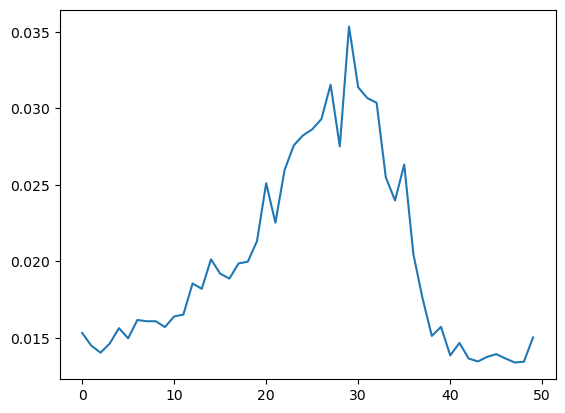

In [71]:
plt.plot(np.mean(pc1_marginal_prob, axis=0))

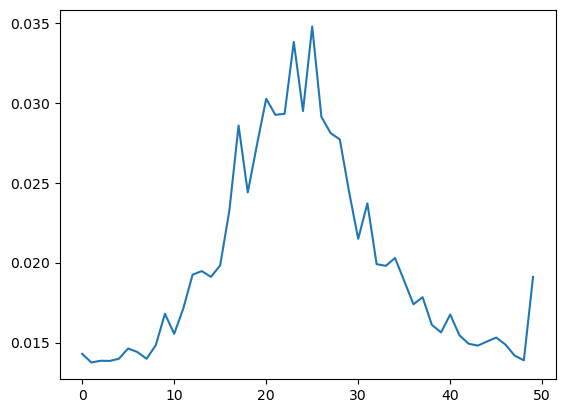

In [76]:
plt.plot(np.mean(pc2_marginal_prob, axis=0))

In [51]:
pc1_marginal_entropy = np.array([scipy.stats.entropy(x) for x in pc1_marginal_prob])
pc2_marginal_entropy = np.array([scipy.stats.entropy(x) for x in pc2_marginal_prob])

In [52]:
pc1_entropy = np.mean(pc1_marginal_entropy, axis=0)
pc2_entropy = np.mean(pc2_marginal_entropy, axis=0)

In [53]:
pc1_entropy

3.8599483833409853

In [54]:
pc2_entropy

3.8616269821654816

In [55]:
pc1_entropy + pc2_entropy

7.721575365506467

In [6]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240827'

Means: []
Whiskers: []


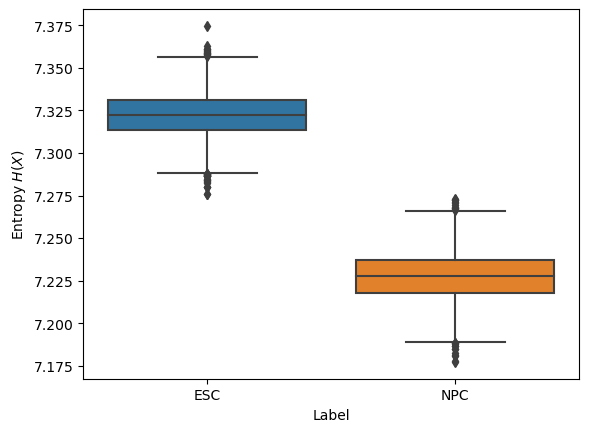

In [7]:

ax = sns.boxplot(x='label', y='entropy', data=all_entropy_df)

# Extract components
means = []
whiskers = []

# Loop through each box in the plot
for i, artist in enumerate(ax.artists):
    # The artist is the box, we can get the x-coordinates for the whiskers
    box_data = artist.get_path().vertices
    box_x = box_data[:, 0]
    box_y = box_data[:, 1]
    
    # The median is the middle line of the box
    median = ax.lines[2 * i + 1].get_ydata()[0]
    means.append(median)
    
    # The whiskers are the lines, each box has two whiskers
    whiskers.append([ax.lines[4 * i].get_ydata()[1], ax.lines[4 * i + 2].get_ydata()[1]])

print("Means:", means)
print("Whiskers:", whiskers)

plt.xlabel('Label')
plt.ylabel(r'Entropy $H(X)$')
plt.savefig(os.path.join(save_dir, 'entropy_boxplot_esc_cnc_50x50.png'), dpi=300, bbox_inches='tight')



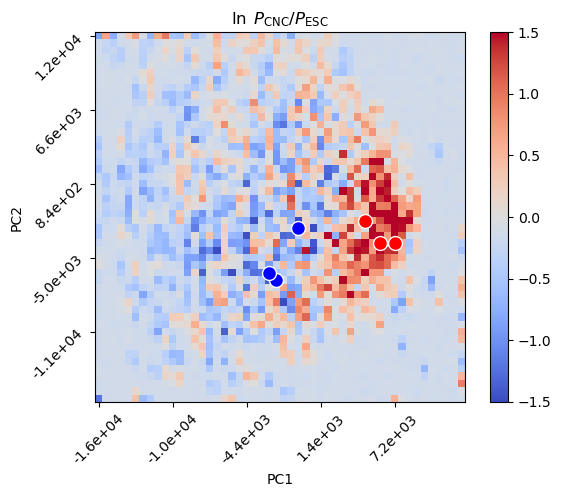

In [8]:
esc_weights_grid = esc_weights_df['weight'].values.reshape(num_metastructures, num_metastructures).T
cnc_weights_grid = cnc_weights_df['weight'].values.reshape(num_metastructures, num_metastructures).T

diff_table = np.log(cnc_weights_grid / esc_weights_grid)

# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[-10:]

# Convert the flattened indices back to 2D indices
top_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
top_10_indices = list(zip(top_10_indices[0], top_10_indices[1]))

# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[:10]

# Convert the flattened indices back to 2D indices
bottom_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
bottom_10_indices = list(zip(bottom_10_indices[0], bottom_10_indices[1]))

plt.imshow(np.log(cnc_weights_grid / esc_weights_grid), cmap='coolwarm', vmin=-3/2, vmax=3/2)
plt.colorbar()
plt.xticks(np.arange(0, num_metastructures, 10), [f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()][::10], rotation=45)
plt.yticks(np.arange(0, num_metastructures, 10), [f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()][::-10], rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(r'$\ln \; P_\mathrm{CNC}/P_\mathrm{ESC}$')
plt.savefig(os.path.join(save_dir, 'prob_ratio.png'), dpi=300, bbox_inches='tight')

# Annotate the top 3 highest values
for i in range(1, 4):
    plt.scatter(top_10_indices[-i][1], top_10_indices[-i][0], color='red', s=100, edgecolor='white')
    # plt.text(top_10_indices[-i][0], top_3_coords[-i][1], f'{data[top_3_coords[0][i], top_3_coords[1][i]]:.2f}', 
    #          color='white', ha='center', va='center', fontsize=9, fontweight='bold')
    
for i in range(3):
    plt.scatter(bottom_10_indices[i][1], bottom_10_indices[i][0], color='blue', s=100, edgecolor='white')

plt.savefig(os.path.join(save_dir, 'cnc_esc_prob_ratio_annotate.png'), dpi=300, bbox_inches='tight')

In [9]:
np.sum(cnc_weights_grid)  # should be 1 

0.9999999999989877

In [10]:
np.sum(esc_weights_grid)  # should be 1

0.9999999999841958

In [11]:
kbT = scipy.constants.k * (273+25)

In [12]:
esc_free_energy = -np.log(esc_weights_grid) * kbT

In [13]:
cnc_free_energy = -np.log(cnc_weights_grid) * kbT

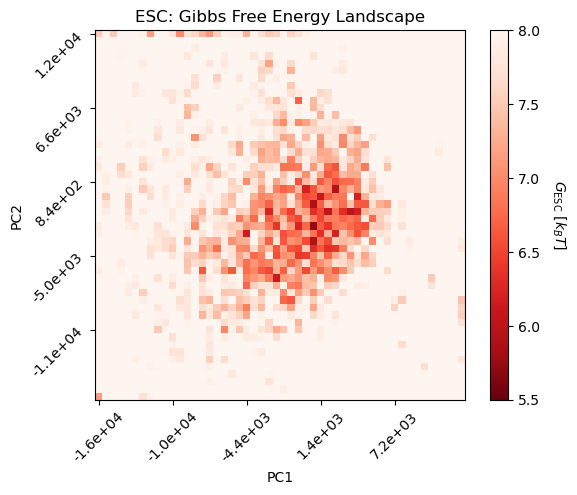

In [14]:
plt.imshow(esc_free_energy/kbT, cmap='Reds_r', vmin=5.5, vmax=8)
cb = plt.colorbar()
cb.set_label(r'$G_\mathrm{ESC}$ $[k_BT]$', rotation=270, labelpad=20)
plt.xticks(np.arange(0, num_metastructures, 10), [f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()][::10], rotation=45)
plt.yticks(np.arange(0, num_metastructures, 10), [f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()][::-10], rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC: Gibbs Free Energy Landscape')
plt.savefig(os.path.join(save_dir, 'free_energy_esc.png'), dpi=300, bbox_inches='tight')

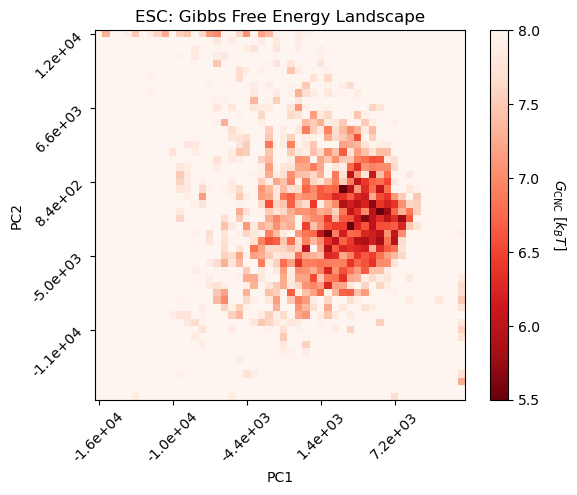

In [15]:
plt.imshow(cnc_free_energy/kbT, cmap='Reds_r', vmin=5.5, vmax=8)
cb = plt.colorbar()
cb.set_label(r'$G_\mathrm{CNC}$ $[k_BT]$', rotation=270, labelpad=20)
plt.xticks(np.arange(0, num_metastructures, 10), [f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()][::10], rotation=45)
plt.yticks(np.arange(0, num_metastructures, 10), [f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()][::-10], rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC: Gibbs Free Energy Landscape')
plt.savefig(os.path.join(save_dir, 'free_energy_cnc.png'), dpi=300, bbox_inches='tight')

In [16]:
# Study the free energy along one dimension
# We will study the free energy difference along the PC1 axis
diff_table_28 = diff_table[28, :]


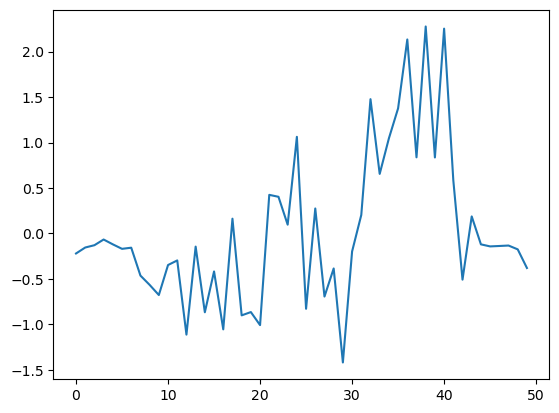

In [17]:
plt.plot(diff_table_28)

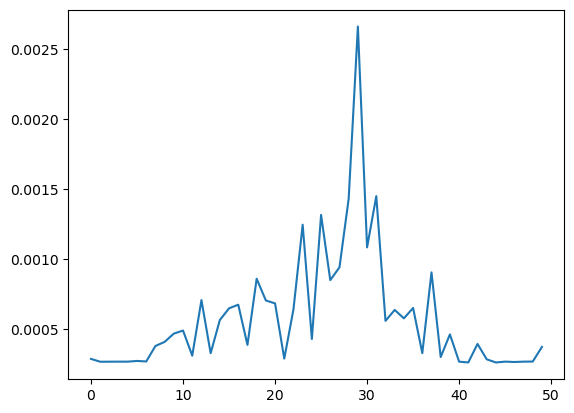

In [18]:
esc_table_28 = esc_weights_grid[28, :]
plt.plot(esc_table_28)

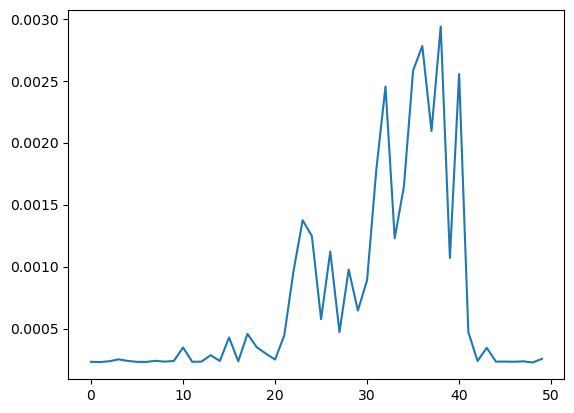

In [19]:
cnc_table_28 = cnc_weights_grid[28, :]
plt.plot(cnc_table_28)

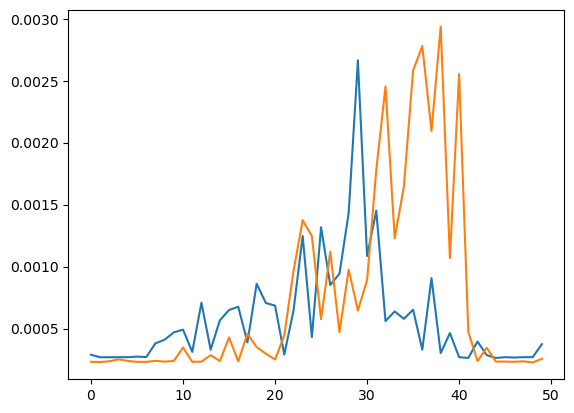

In [20]:
plt.plot(esc_table_28)
plt.plot(cnc_table_28)

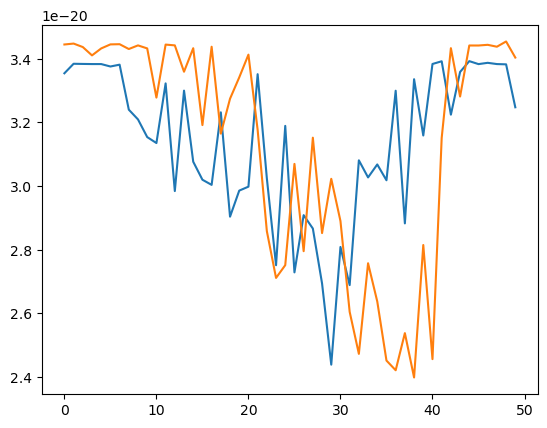

In [21]:
plt.plot(esc_free_energy[28, :])
plt.plot(cnc_free_energy[28, :])

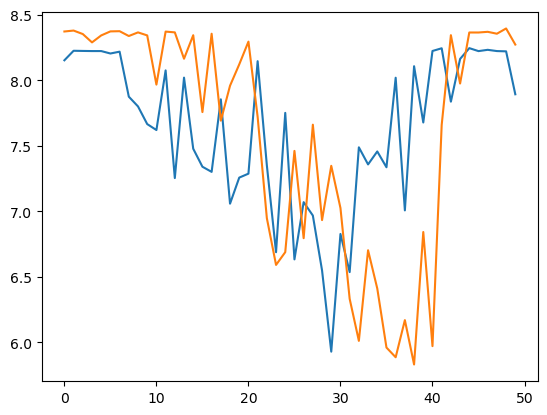

In [22]:
plt.plot(esc_free_energy[28, :] / kbT)
plt.plot(cnc_free_energy[28, :] / kbT)